#***Task List***
*NOTE: This task list doesn't include a full history of work done on this project because this notebook is a continuation of a the code I wrote to classify the Emobank Dataset. Because I wanted to keep my original code for reference, I created a copy of that previous notebook to work on I could refine and edit the model for a better dataset*
- [x] Clean Up and Structure Model Notes
  * [x] Text Boxes
  * [x] Comments
* [x] Import and Preprocess [*Emotions Dataset for NLP*](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp?select=train.txt)
  * [x] Import Data from Kaggle
* [x] Generalize and Optimize Sanitization Functions
  * [x] Needs to work with additional datasets
* [ ] Tune Dataset
  * [ ] Balance Classes
    * Balance Seperate Datasets?
  * [ ] Create Proper Test Dataset

#### Potential Actions
* Seperate Transformer Training and Classifier Training
  * More BERT like approach
* Use Twitter Corpus from [Kaggle](https://www.kaggle.com/ishivinal/tweet-emotions-analysis-using-lstm-glove-roberta/#data)


# BERT Based Transformer for Emotional Sentiement Analysis 
* The transformer code here is based off of a [tutorial](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html) by Google
  * Aside from specified layers, all the code taken from that tutorial was hand recoded and commented in order to ensure understanding
  * Modifications were made to the tutorial code in order to use the transformer for BERT style classification rather than translation
  * **The data tokenization code was largely self-developed.**
    * Since this model needs to be converted to TensorflowJS, a custom tokenization function needed to be created.
    * This custom function uses ideas from the HuggingFace BERT tokenizer
* For this project, I considered fine tuning a BERT transformer from the HuggingFace transformer library, but instead I decided to write the transformer using Keras in order to both develop a greater understanding of NLP and challenge myself.
  * So even though I did use a tutorial to write the transformers code, I do actually understand the arcitecture of the model and the Keras functional API used to write it.
  * **`Link to Transformer Notes and Keras Functional API Playground`**

In [1]:
# Imports the needed libraries

# Used for preparing the text for training
import pandas as pd
import re

# Used for storing the dataset and creating the model
import numpy as np
import tensorflow as tf

# TFDS is used for storing and preparing the dataset for training
import tensorflow_datasets as tfds

# Used for exporting the dictionary
import json   

## Dataset Preperation

### Download Datasets




In [2]:
# Downloads the journal emotions dataset which classifies journal-like text entries with different emotions
!curl -LO https://github.com/sentimentapp/core/raw/main/datasets/journal_emotions.zip
!mkdir journal_emotions
!unzip -n journal_emotions.zip -d journal_emotions

# Downloads the twitter emotions dataset which classifies tweets with different emotions
!curl -LO https://github.com/sentimentapp/core/raw/main/datasets/twitter_emotions.zip
!mkdir twitter_emotions
!unzip -n twitter_emotions.zip -d twitter_emotions

# Removes sample_data directory to clean up file system
!rm -rf sample_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   152  100   152    0     0   1020      0 --:--:-- --:--:-- --:--:--  1020
100  721k  100  721k    0     0  1839k      0 --:--:-- --:--:-- --:--:-- 1839k
Archive:  journal_emotions.zip
  inflating: journal_emotions/test.txt  
  inflating: journal_emotions/train.txt  
  inflating: journal_emotions/val.txt  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   152  100   152    0     0    663      0 --:--:-- --:--:-- --:--:--   660
100 1912k  100 1912k    0     0  2787k      0 --:--:-- --:--:-- --:--:-- 2787k
Archive:  twitter_emotions.zip
  inflating: twitter_emotions/text_emotion.csv  


### Load the Data to Pandas Dataframes
* The idea here is to use a sentiment dataset of journal-like entries along with a dataset of twitter entries. The following code aims to prepare the twitter data to merge with the journaling dataset.

In [3]:
# Imports the journal train file as a Pandas Dataframe
journal = pd.read_csv("journal_emotions/train.txt", sep=";", names=["text", "sentiment"], header=None)


# Imports the twitter csv as a Pandas Dataframe
twitter_full = pd.read_csv("twitter_emotions/text_emotion.csv")
# Removes the tweet_id and author columns
twitter_full = twitter_full[["sentiment", "content"]]
# Renames columns to match the journal
twitter_full.columns = ["sentiment", "text"]

# Checks the imports
print("JOURNAL:")
print(journal.head())
print("----------------------------------------------------------------")
print("TWITTER:")
print(twitter_full.head())

JOURNAL:
                                                text sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger
----------------------------------------------------------------
TWITTER:
    sentiment                                               text
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...


#### Split Data into Training and Testing

In [4]:
def split_data(dataframe, split):
  # Shuffles the dataframe before the split
  dataframe = dataframe.sample(frac=1)

  # Creates a mask of True and False that matches the split percentage
  msk = np.random.rand(len(dataframe)) < split

  # Returns two datasets
  return dataframe[msk], dataframe[~msk]


twitter, twitter_test = split_data(twitter_full, 0.9)

# Loads the journal_test from a seperate file
# Twitter test data created with split data function because it wasn't seperate files
journal_test = pd.read_csv("journal_emotions/test.txt", sep=";", names=["text", "sentiment"], header=None)

### Dataset Distribution
* Figure out what labels each dataset has and how much of each label
* This information is used to figure out how to manage the data.
* **For this model the *journal datasets* 6 emotions are going to be used for the overall classification.** This means that 13 emotions of the twitter dataset need to be remapped

In [5]:
# Finds the distribution of data to help figure out how to prepare the data
def find_data_distribution(dataframe, label_column):
  # Creates an array with all the unique labels for the data
  print(dataframe[label_column].value_counts())

# Looks at the distribution
print("JOURNAL:")
find_data_distribution(journal, "sentiment")
print("-------------------------------------")
print("TWITTER:")
find_data_distribution(twitter, "sentiment")

JOURNAL:
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64
-------------------------------------
TWITTER:
neutral       7760
worry         7529
happiness     4675
sadness       4625
love          3469
surprise      1969
fun           1598
relief        1387
hate          1211
empty          748
enthusiasm     677
boredom        168
anger           95
Name: sentiment, dtype: int64


### Match Datasets With Each Other

This is how the entries of the twitter dataset are being adjusted to fit the journal dataset. Similar emotions are being mapped together, and emotions with too little data or emotions  that don't quite match the six caterogires of the journal dataset are removed.

* Adjust Twitter Emotion Types:
  * Change:
    * Anger, Hate -> Anger
    * Worry -> Fear
    * Happiness, Fun -> Joy
  * Same:
    * Love -> Love
    * Sadness -> Sadness
    * Surprise -> Surprise
  * Remove:
    * Empty, Enthusiasm, Neutral, Boredom, Relief -> Removed

##### Remove Rows Function

In [6]:
# Removes rows from the dataset
def remove_rows(dataframe, label_column, remove_array):
  # Loops through the emotions in the remove_array
  for emotion in remove_array:
    # Removes any rows with that emotions
    dataframe.drop(dataframe[dataframe[label_column] == emotion].index, inplace = True)
  
  return dataframe

# Removes rows with uneeded emotions 
twitter = remove_rows(twitter, "sentiment", ["empty", "enthusiasm", "boredom", "relief"])

##### Replace Label Values Function

In [7]:
# Changes out sentiment values to make the two datasets consistent
def replace_label_value(dataframe, label_column, replace_dictionary):
  for to_replace, replace_with in replace_dictionary.items():
    dataframe.loc[(dataframe[label_column] == to_replace), label_column] = replace_with

  return dataframe

# Dictionary of terms to replace
# "word to replace": "word that replaces it"
replace = {
    "hate": "anger",
    "worry": "fear",
    "fun": "joy",
    "happiness": "joy",
}

# Matches the labels of the twitter dataset to the journal
twitter = replace_label_value(twitter, "sentiment", replace)

#### Average Sentence Length

In [8]:
# Gets the average length of a sentence to help figure out training parameters
def average_length(dataframe, data_column):
  average = dataframe[data_column].astype(str).apply(lambda x:len(x.split())).mean()
  print("Average Sentence Length:", average)

Average Label Entry Amount

In [9]:
# Used to get the average label amount
# Helps to figure out datasize for balancing the dataset
def average_label(dataframe, label_column):
  print("Average Datapoints per Label:", dataframe[label_column].value_counts().mean())

#### Balance Dataset

In [10]:
# Balances the dataset through downsampling
# However, if a specific count value is specified the function will downsample AND oversample
def balance_dataset(dataframe, label_column, count=0):
  if (count == 0):
    # Gets the row count of the label with the least amount of data
    count = (dataframe[label_column].value_counts())[-1]

  # Gets the different labels for looping
  labels = dataframe[label_column].unique()

  # Creates an empty dataframe to store the downsampled array in
  down_sampled = pd.DataFrame(columns = dataframe.columns)

  # Loops through each of the different labels
  for label in labels:
    # Creates a dataframe that only has one specific label
    label_sample = dataframe[dataframe[label_column] == label]
    # Samples a random distribution of those labels
    label_sample = label_sample.sample(count, replace=True)
    # Places the downsampled data into the empty array
    down_sampled = pd.concat([down_sampled, label_sample])

  return down_sampled

### Combine the Twitter and Journal Dataframes

In [11]:
# Combines the two datasets
combined_data = pd.concat([journal, twitter])
# Prints the average sentence length to provide insight into dataset creation
average_length(combined_data, 'text')

# Prints the average data for a label to help figure out balancing
average_label(combined_data, 'sentiment')


# Balances the different entries
combined_data = balance_dataset(combined_data, 'sentiment', count=5000)

find_data_distribution(combined_data, "sentiment")

Average Sentence Length: 15.169953608142078
Average Datapoints per Label: 6990.142857142857
anger       5000
joy         5000
neutral     5000
love        5000
surprise    5000
sadness     5000
fear        5000
Name: sentiment, dtype: int64


#### Create Combined Test Dataframe

In [12]:
# These functions match the test data to the training data; they are copied from the previous functions
#-------------------------------------------------------------------------------------------------------------------
# Removes rows with uneeded emotions 
twitter_test = remove_rows(twitter_test, "sentiment", ["empty", "enthusiasm", "boredom", "relief"])

# Dictionary of terms to replace
# "word to replace": "word that replaces it"
replace = {
    "hate": "anger",
    "worry": "fear",
    "fun": "joy",
    "happiness": "joy"
}

# Matches the labels of the twitter dataset to the journal
twitter_test = replace_label_value(twitter_test, "sentiment", replace)
#-------------------------------------------------------------------------------------------------------------------

combined_test = pd.concat([journal_test, twitter_test])


find_data_distribution(combined_test, "sentiment")

joy         1407
fear        1154
sadness     1121
neutral      878
love         532
anger        402
surprise     284
Name: sentiment, dtype: int64


## Tokinzation 
* The tokenization function uses the [BERT Base Uncased Vocabulary Set](https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt) in order to train 
* Words not present in the BERT Base dictionary are split into parts
  * Parts of split words start with '##'
* [Helpful Analysis of BERT Vocab](http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html)


### Download BERT Dictionary

In [13]:
# Downloads the BERT Base Vocabulary
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt

# Renames the text file to something simpler
!mv bert-base-uncased-vocab.txt vocab.txt

--2020-12-26 23:12:11--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  --.-KB/s    in 0.04s   

2020-12-26 23:12:11 (5.56 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



### Create BERT Dictionary

In [14]:
# Creates dictionaries for the vocab terms and their token numbers
# Using a dictionary makes it quick and easy to search for a word's token and vice-versa
VOCAB_TO_INDEX = {}
INDEX_TO_VOCAB = {}

# Size of the models vocabulary
VOCAB_SIZE = 0

# Loops through the different vocab words in the BERT file
with open("vocab.txt", "r") as vocab:
  for i, word in enumerate(vocab):

    # Removes \n (new line character) the end of the words
    word = word.rstrip()

    # Creates the needeed word/index entry in both dictionaries
    # The index starts at 1 because padded "words" are represented with 0
    VOCAB_TO_INDEX[word] = i + 1
    INDEX_TO_VOCAB[i + 1] = word
  
  # Adds 1 because i starts at 0 while the word indices start at 1
  VOCAB_SIZE = i + 1

### Word Tokenization Function


In [15]:
# Returns the tokenized version of a word from the dictionary
# Splits unknown words into different sections
def tokenize_word(word):

  # Stores the returned tokens
  token_array = []

  # ------------------------------------------------------------
  # Used for printing the actual parts of each word in debugging
  # DEBUGGING_ARRAY = []
  # ------------------------------------------------------------

  # Runs until each part of the word has been converted to a token
  while (len(word) != 0):
    # Loops backwards through the word to ensure longest segments are the word are found
    for i in range(len(word), -1, -1):

      # Stores the word segment being examined
      substring = word[0: i]

      # Removes a character from an input if the character isn't present in the dictionary
      if (len(substring) == 0):
        word = word[1: len(word)]
        break

      # For the first part of the word added to the token array don't use the '##' seperator 
      elif (len(token_array) == 0):
        if (VOCAB_TO_INDEX.get(substring)):
          token_array.append(VOCAB_TO_INDEX[substring])
          word = word[i: len(word)]
          break

      # If other parts of the word have already been tokinzed, add a '##' in front of the segment to indicate that it is a part of the word
      else:
        if (VOCAB_TO_INDEX.get("##" + substring)):
          token_array.append(VOCAB_TO_INDEX["##" + substring])
          word = word[i: len(word)]
          break
  
  # -------------------------------------------------------
  # Debugging: Returns actual word parts rather than tokens
  #
  # for index in token_array:
  #   DEBUGGING_ARRAY.append(INDEX_TO_VOCAB[index])
  # --------------------------------------------------------

  # Only returns the array if there is data in it
  if (token_array):
      return token_array #, DEBUGGING_ARRAY

## Create Dataset

### Sanitization Function
* Removes:
  * Twitter Handles
  * Links
  * Hashtags
  * Uppercase Letters
  * Special Characters

In [16]:
# Prepares the sentences to be processed by the network
def sanitize_text(text):
  # Sets the text to lowercase
  text = text.lower().strip()


  # Removes links
  text = re.sub(r'http\S+', '', text)

  # Removes twitter usernames
  text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', text)

  # Removes hashtags
  text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9-_]+)', '', text)

  # Creates a space between a word and the following punctuation
  text = re.sub(r"([?.!,])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)

  # Removes all characters but (a-z, A-Z, ".", "?", "!", ",")
  text = re.sub(r"[^a-zA-Z?.!,]+", " ", text)
  text = text.strip()

  return text

# Test the function
sanitize_text("@myfriend #podcast Check out this really cool link https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas it is ~~~amazing~~~")

'check out this really cool link it is amazing'

### Create Dataset Array

In [17]:
# Stores the maximum sentence length observed by the transformer
MAX_SENTENCE_LENGTH = 20#@param {type:"integer"}

# Create an array of labels for automatic data labeling
LABEL_REF = combined_data["sentiment"].unique()
LABEL_AMOUNT = len(LABEL_REF)

# Uses previously defined functions to create a final dataset.
def create_data_set(dataframe, inputs_column, outputs_column, label_ref):

  # Cleans up the input column
  dataframe[inputs_column] = dataframe[inputs_column].apply(sanitize_text)

  # Gets the length of the data in order to construct numpy arrays
  dataset_length = len(dataframe.index)
  
  # Creates arrays that stores inputs and outputs that were extracted from the dataset
  dataset_inputs = np.zeros([dataset_length, MAX_SENTENCE_LENGTH])

  # Gets the label amount to create the outputs
  label_amount = len(LABEL_REF)
  dataset_outputs = np.zeros([dataset_length, label_amount])

  # Processes each row of the provided dataframe
  for i, row in enumerate(dataframe[inputs_column]):

    # INPUTS
    # Converts the sentence into an array
    word_list = re.sub("[^a-zA-Z?.!,]", " ",  row).split()

    # Adds BERT [CLS] token to the row
    # This token is what is evaluted by the final dense layer to create the prediction
    word_list.insert(0,'[CLS]')

    # Variable that stores the tokinzed sentence from the examined row
    tokenized_sentence = []
  

    # Appends each tokenized word to the tokenized_sentence array
    for word in word_list:
      tokenized_sentence.extend(tokenize_word(word))

    # Truncates the sentence if it is over the MAX_SENTENCE_LENGTH
    del tokenized_sentence[MAX_SENTENCE_LENGTH:]

    # Passes the tokenized words from the tokenized_sentence array to the returned dataset
    for j, token in enumerate(tokenized_sentence):
      dataset_inputs[i][j] = token

  #-------------------------------------------------------

  # OUTPUTS
  # Sets the output equal to the VAD values of the text
  for i, row in enumerate(dataframe[outputs_column]):
    label_index = np.where(LABEL_REF == row)
    dataset_outputs[i][label_index] = 1

  # Returns inputs and outputs for training
  # Converted to float32 in order to save memory during training
  return tf.cast(dataset_inputs, tf.float32), tf.cast(dataset_outputs, tf.float32)


# Inputs used for training and label index for future reference
inputs, outputs = create_data_set(combined_data, "text", "sentiment", LABEL_REF)

# Creates the test data array as well
inputs_test, outputs_test = create_data_set(combined_test, "text", "sentiment", LABEL_REF)

### *Debugging: Verify Dataset Array*


In [18]:
# Debugging function that can be used to make sure sentences were properly tokenized
def check_tokenizer(index, inputs, outputs, dataframe, inputs_column, outputs_column):
  
  # String that stores the tokens that have been converted to words
  token_converted = ""

  # Loops through all of the tokens from a row of data
  # Exits when it reaches the end of the sentence
  for token in inputs[index]:
    if (token == 0):
      break

    # Get a token's corresponding word
    word = INDEX_TO_VOCAB[token.numpy()]

    # If the "word" returned in a continuation of another, remove the ## from it
    if "##" in word:
      token_converted += word[2:]
    # If it is just a normal word, add it to the string
    else:
      token_converted += " " + INDEX_TO_VOCAB[token.numpy()]

  # Prints the detokenized results, and the origional results from the pandas dataframe. 
  print("INPUTS:")
  # [7:] Skips CLS token
  print(token_converted[7:])
  print(dataframe[inputs_column].iloc[index], "\n")

  print("OUTPUTS:")
  print(dataframe[outputs_column].iloc[index])
  print(LABEL_REF[np.where(outputs[index] == 1)][0])

check_tokenizer(4509, inputs, outputs, combined_data, "text", "sentiment")

INPUTS:
boyfriend is out with friends tonight . don t know what to do with my evening
boyfriend is out with friends tonight . don t know what to do with my evening 

OUTPUTS:
sadness
sadness


### Create tf.data.Dataset

In [19]:
# TRAINING DATA
# -------------------------------------------------------------------------------------------------
# Amount of data passed through each training iteration
BATCH_SIZE =  1024#@param {type:"integer"}
# Uniformity of data shuffling
BUFFER_SIZE = 50000

# Creates the final dataset to be used for training
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': inputs
    },
    {
        'outputs': outputs
    },
))

# Caches the dataset in memory or local storage to prevent file opening and data reading
dataset = dataset.cache()
# Shuffles the data
dataset = dataset.shuffle(BUFFER_SIZE)
# Seperates the data into batch sizes
dataset = dataset.batch(BATCH_SIZE)
# Extracts the next batch of data while one is training
# Uses the AUTOTUNE function to automatically figure out how many batches can be preprocessed
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)



# TESTING DATA
# -------------------------------------------------------------------------------------------------
# Creates the dataset to be used for validation
dataset_test = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': inputs_test
    },
    {
        'outputs': outputs_test
    },
))

# Caches the dataset in memory or local storage to prevent file opening and data reading
dataset_test = dataset_test.cache()
# Shuffles the data
dataset_test = dataset_test.shuffle(BUFFER_SIZE)
# Seperates the data into batch sizes
dataset_test = dataset_test.batch(BATCH_SIZE)
# Extracts the next batch of data while one is training
# Uses the AUTOTUNE function to automatically figure out how many batches can be preprocessed
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

## Transformer
[Code Based Off Google Transformer Chatbot](https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/transformer_chatbot.ipynb)

### *Debugging: Print Function*
* The main use of this function is to print the size of matrices during training. This transformer is defined using None sizes in order to make sure that it can fit a variety of different datasizes. As such, sizes of the matrices after running through the different layers aren't know until runtime. This function fixes this problem by allowing for the matrix sizes to be examined during model training.

In [20]:
# Keras layer that adds printing functionality to the model graph
class Print(tf.keras.layers.Layer):
  def __init__(self, name="print"):
    super().__init__()

  # Returns the original input, but also prints the size of a matrix to console during training
  def call(self, inputs):
    tf.print("\n", tf.shape(inputs))
    return inputs

### Attention Mechanisms

#### Padding Mask


In [21]:
# Generates a mask that is used to prepare padded data for the self attention function
def create_padding_mask(inputs):
  # tf.math.equal checks for values that equal 0 in the array passed to it
  # It then returns an array with a 1 where the original array equaled 0, and 0s everywhere else
  # The array is also cast float32 for faster training
  mask = tf.cast(tf.math.equal(inputs, 0), tf.float32)

  # Reformats the attention mask to match the shape of multihead self-attention
  return mask[:, tf.newaxis, tf.newaxis, :]

#### Self-Attention
* The self-attention function is an equation that origionally came from the paper *Attention is All You Need*.
* This function takes a setence converted to [word vectors](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/)—an abtract numerical representations of a word's meaning—and embeds each vector with the meaning of the other vectors in the sentence.

In [22]:
def self_attention(query, key, value, mask):

  # Matrix multiplies the query and key vectors to get a "score" for how related two words are
  score = tf.matmul(query, key, transpose_b=True)

  # Gets the size of the key vector
  key_vector_dimensions = tf.cast(tf.shape(key)[-1], tf.float32)
  # Divides the score (query x key) by the square root of the key vector size in order to create more stable gradients
  score_stablized = score / tf.math.sqrt(key_vector_dimensions)

  # A mask created with the padding_mask function is passed here
  # An input of [1, 0, 6, 4] would have a mask of [0, 1, 0, 0]
  # This mask sets the padded zeros in an input to "-inf" in order to make sure the padded values are not read as words
  if mask is not None:
    score_stablized += (mask * -1e9) 

  # Softmax layer normalizes all the different word scores
  attention_weights = tf.nn.softmax(score_stablized, axis=-1)

  # Mutliplies the attention weights the input values in order to get the final "summary" vector
  output = tf.matmul(attention_weights, value)

  return output


#### Multihead Self-Attention

In [23]:
class MultiheadSelfAttention(tf.keras.layers.Layer):

  # In the Keras functional API, the __init__ layer is used to define model weights
  def __init__(self, output_dimensions, num_heads, name="multi_head_attention"):
    # Initializes the tf.keras.layers.Layer superclass
    super().__init__()

    # Number of nodes in the dense layer (output_dimensions) and the number of self-attention heads
    self.output_dimensions = output_dimensions
    self.num_heads = num_heads

    # The number of dimensions needs to be divisible by the number of attention heads in order to make sure that the data can be properly transposed
    assert output_dimensions % self.num_heads == 0

    # Stores the size of the vetor examined by each attention head
    self.depth = output_dimensions // self.num_heads

    # These dense layers learn the associations in the word vectors
    self.query_dense = tf.keras.layers.Dense(units=output_dimensions)
    self.key_dense = tf.keras.layers.Dense(units=output_dimensions)
    self.value_dense = tf.keras.layers.Dense(units=output_dimensions)

    # Dense layer used after all the self-attention heads are added back together
    self.dense = tf.keras.layers.Dense(units=output_dimensions)

  # Reshapes the data into seperate sections for each of the attention heads
  def split_heads(self, inputs, batch_size):
    # Reshapes the data so each head has a section to examine
    inputs = tf.reshape(
        inputs,
        shape=(batch_size, -1, self.num_heads, self.depth))
    # Transposes the data so that each new section of data is processed individually by the self_attention function
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  # The function that actually runs the commands for the layer because call() is equivelent to __call()__
  def call(self, inputs):
    # Only one variable can be passed to the call function so the inputs are passed as a dictionary
    # inputs['query'], inputs['key'], inputs['value'] are all just equal to inputs. 
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']

    # Gets the size of the batch passed to the function by the Keras Dataset API
    batch_size = tf.shape(query)[0]

    # Runs the inputs through dense layers in order to get custom query, key, value vectors
    query = self.query_dense(query)
    key = self.query_dense(key)
    value = self.query_dense(value)

    # Uses the split_heads function to format all the new vectors for multihead attention
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Runs the data through the attention heads
    processed_attention = self_attention(query, key, value, mask)

    # Un-transposes the data and concatenates the results for each head
    processed_attention = tf.transpose(processed_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(processed_attention, shape=(batch_size, -1, self.output_dimensions))

    # Runs the returned vector through a final dense layer to make a final connections between data points
    outputs = self.dense(concat_attention)

    return outputs

### Positional Encoding
* Code here taken directly from this [tutorial](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html) from Google
  * Code without this label was either self-developed or rewritten in order to develop an understand of the code.
* For a deeper understanding of positional encoding check out this [repository](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb)

In [24]:
# Transformers don't process words sequentially.
# As such, this positional encoding equation is used to embed the positional data into each word vector

# While the other code from the tutorial was hand written and recommented in order to ensure understanding
# the class written below was taken directly from the tutorial listed in the Transformer header of this notebook.

# As such, the comments.
# While I would have liked to spend time getting to understand this operation, it was not a critical task for this project
# I choose instead to focus my energy on understanding the naunces of the transformer architecture 

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, output_dimensions):
    super(PositionalEncoding, self).__init__()
    # Creates a variable that stores the positional encoding data
    self.pos_encoding = self.positional_encoding(position, output_dimensions)

  # Computes the inner value of the sin and cos functions
  def get_angles(self, position, i, output_dimensions):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(output_dimensions, tf.float32))
    return position * angles

  def positional_encoding(self, position, output_dimensions):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(output_dimensions, dtype=tf.float32)[tf.newaxis, :],
        output_dimensions=output_dimensions)
    # Apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # Combines the results of the sin and cos operations
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

#### Encoder Layer

In [25]:
# This function create a Keras model that represents a single encoder layer
# In a transformer, the encoder is reponsible for abstracting the data
def encoder_layer(dense_dimensions, output_dimensions, num_heads, dropout_rate, name="encoder_layer"):
  # Because this function outputs a Keras model, input layerw need to be defined
  inputs = tf.keras.Input(shape=(None, output_dimensions), name="inputs")
  # Padding mask created with the padding_mask function 
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Multihead Self-Attention layer that was previously defined
  # This layer is ultimately reponsible for figuring out the connections between words
  attention = MultiheadSelfAttention(
      output_dimensions, num_heads, name="self_attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Dropout layer ignores random values from the attention matrix during training to help prevent overfitting 
  attention = tf.keras.layers.Dropout(rate=dropout_rate)(attention)
  # Normalization layer adds the attention outputs to the original inputs and then normalizes the result
  # This keeps a residual connection the model's original input
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # Dense layers do additional processing on the newly minted word vector
  outputs = tf.keras.layers.Dense(units=dense_dimensions, activation='relu')(attention)
  # Converts the data back to the original input dimensions
  outputs = tf.keras.layers.Dense(units=output_dimensions)(outputs)

  # Final dropout and normalization layer
  outputs = tf.keras.layers.Dropout(rate=dropout_rate)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  # Returns a Keras model that is used as a layer in the encoder bloack
  return tf.keras.Model(
      inputs=[inputs, padding_mask],
      outputs=outputs,
      name=name
  )

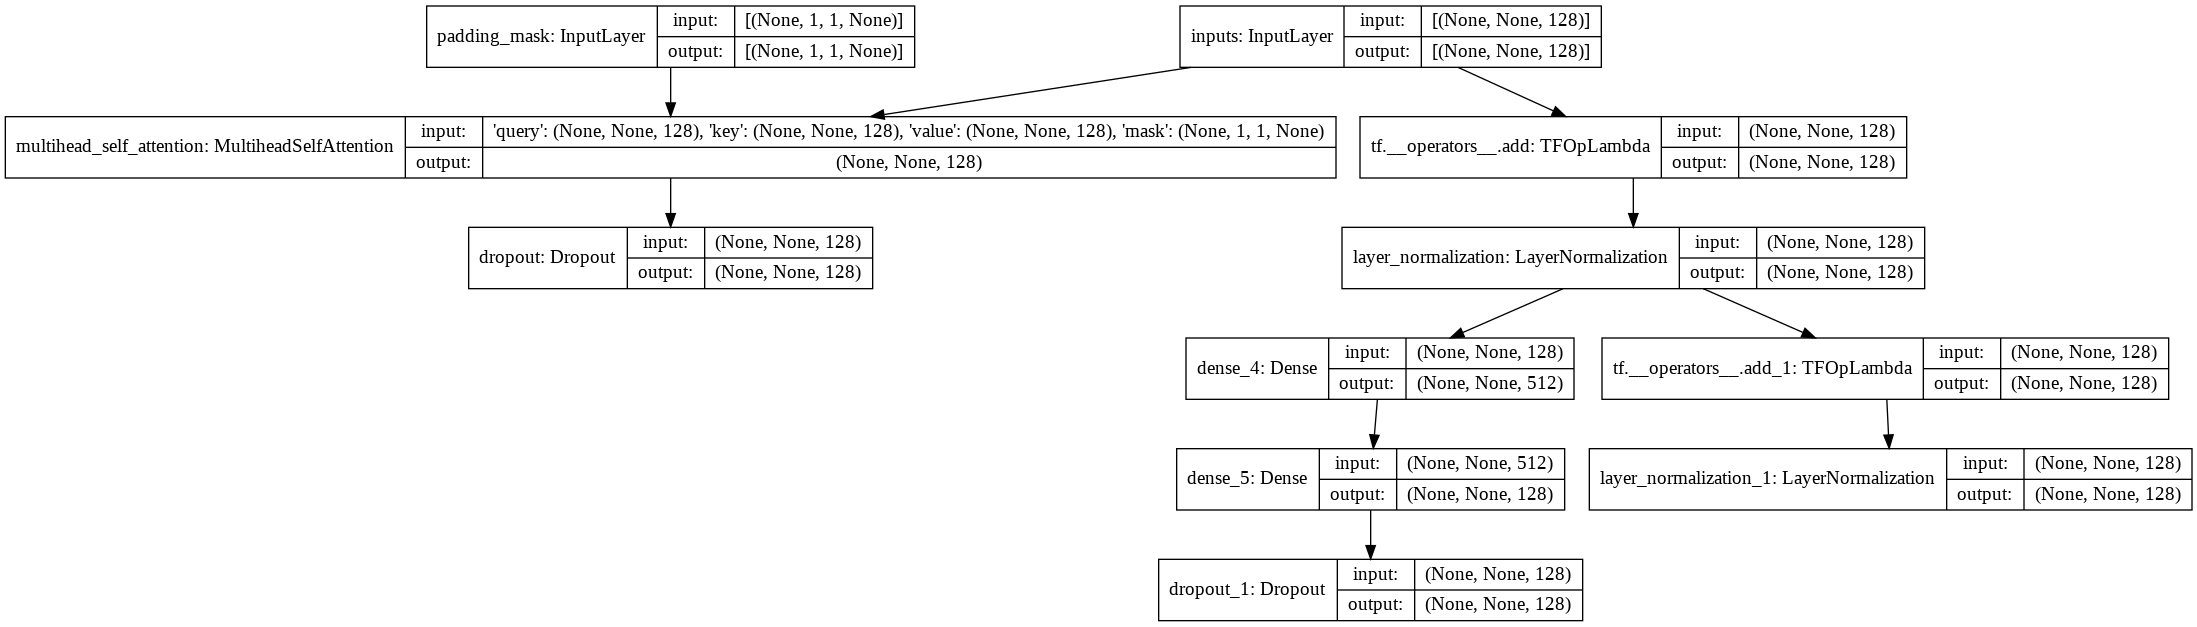

In [26]:
# Creates a sample encoder layer
sample_encoder_layer = encoder_layer(
    dense_dimensions=512,
    output_dimensions=128,
    num_heads=4,
    dropout_rate=0.3,
    name="sample_encoder_layer")

# Makes a folder to store the layer images
!mkdir layer_images

# Outputs a plotted model to check for errors 
tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='layer_images/sample_encoder_layer.png', show_shapes=True)

#### Encoder Block

In [27]:
# This function is used to define the entire encoding block rather than just a single layer
def encoder(vocab_size, num_encoding_layers, dense_dimensions, output_dimensions, num_heads, dropout_rate, name="encoder"):
  # Inputs and padding mask
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Rather than using pretrained embeddings, the transformer trains its own embeddings
  # This function converts the previous defined tokens into embeddings with size output_dimensions
  embeddings = tf.keras.layers.Embedding(vocab_size, output_dimensions)(inputs)

  # Multiplies the embeddings by the square root of the models dimensions
  embeddings *= tf.math.sqrt(tf.cast(output_dimensions, tf.float32))
  # Adds positional data to the embedding layer
  embeddings = PositionalEncoding(vocab_size, output_dimensions)(embeddings)

  # Dropout layer to prevent overfitting
  outputs = tf.keras.layers.Dropout(rate=dropout_rate)(embeddings)

  # This function loops through layers "num_encoding_layers" times
  # Doing this adds "num_encoding_layers" encoding layers to the final encoder block
  #"([outputs, padding_mask])" is the data being passed to the model each time (passing itself)
  for i in range(num_encoding_layers):
    outputs = encoder_layer(
        dense_dimensions=dense_dimensions,
        output_dimensions=output_dimensions,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        name="encoder_layer_{}".format(i)
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask],
      outputs=outputs,
      name=name
  )

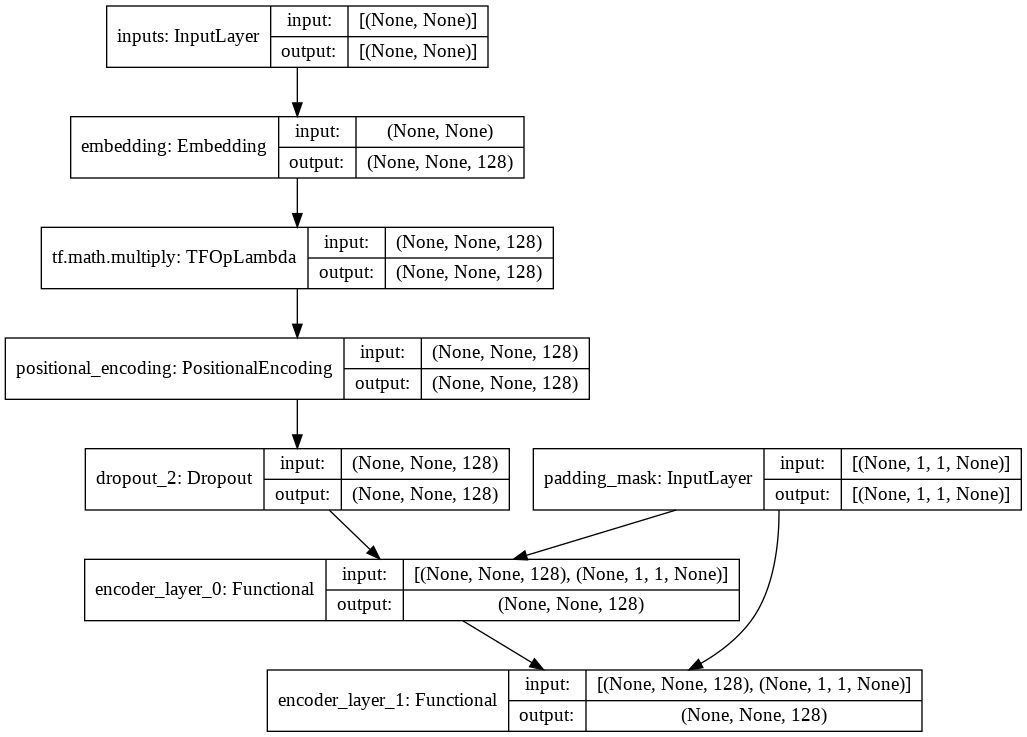

In [28]:
sample_encoder = encoder(
    vocab_size=8192,
    num_encoding_layers=2,
    dense_dimensions=512,
    output_dimensions=128,
    num_heads=4,
    dropout_rate=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
    sample_encoder, to_file='layer_images/sample_encoder.png', show_shapes=True)

### Full Model

In [29]:
# The full BERT based transformer model definition
# A dense layer is at the end to return a classification array
def transformer(vocab_size, num_encoding_layers, dense_dimensions, output_dimensions, num_heads, dropout_rate, output_units, name="transformer"):
  # Inputs for the model
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # Creates the padding mask before the tokens go through the vectorizer
  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, 
      output_shape=(1, 1, None),
      name="padding_mask"
  )(inputs)

  # Creates the encoder block
  encoder_outputs = encoder(
      vocab_size=vocab_size,
      num_encoding_layers=num_encoding_layers,
      dense_dimensions=dense_dimensions,
      output_dimensions=output_dimensions,
      num_heads=num_heads,
      dropout_rate=dropout_rate
  )(inputs=[inputs, padding_mask])


  # Final dense layer that finds any final associations in the data
  outputs = tf.keras.layers.Dense(units=dense_dimensions)(encoder_outputs)
  
  # -----------------------------------------------------------------
  # Can be used to average the arrays instead of having a [CLS] token
  # This seems to yield better performance
  outputs = tf.keras.layers.GlobalAveragePooling1D()(outputs)
  # -----------------------------------------------------------------


  # ------------------------------------------------------
  # Sets the outputs only equal to the [CLS] token
  # The [CLS] token is how BERT does classification tasks
  # outputs = outputs[:, 0, :]
  # ------------------------------------------------------


  outputs = tf.keras.layers.Dense(units=output_units, activation='sigmoid', name="outputs")(outputs)

  return tf.keras.Model(
      inputs=inputs,
      outputs=outputs,
      name=name
  )

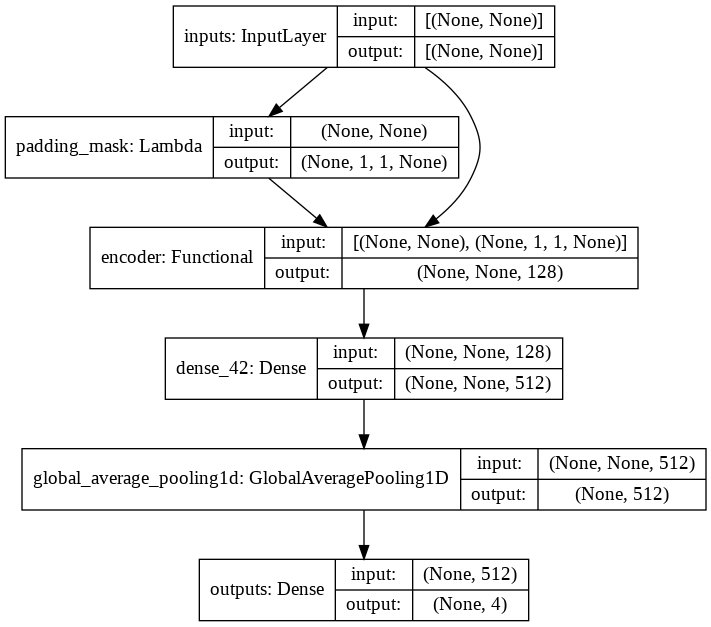

In [30]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_encoding_layers=4,
    dense_dimensions=512,
    output_dimensions=128,
    num_heads=4,
    dropout_rate=0.3,
    output_units=4,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='layer_images/transformer.png', show_shapes=True)

## Training

### Confirm GPU


In [31]:
# Checks to make sure that the transformer is training on a GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
 print('Trainging with GPU at: {}'.format(device_name))
else:
  print('Training with CPU. Switch the runtime to a GPU for faster training')

Training with CPU. Switch the runtime to a GPU for faster training


### Define Model

In [32]:
# Removes any previously created models and layers
# Such as the ones created for the diagrams
tf.keras.backend.clear_session()

# Model Verification
# A parameter that is used for training additional models to find a fit
MODEL_VERIFICATION = False #@param {type:"boolean"}

# Training Parameters
# These can be set using the form function within colab for easier management
NUM_ENCODING_LAYERS =     1#@param {type:"integer"}
OUTPUT_DIMENSIONS =  8#@param {type:"integer"}
NUM_HEADS = 2#@param {type:"integer"}
DENSE_DIMENSIONS =  8#@param {type:"integer"}
DROPOUT_RATE = 0.5#@param {type:"raw"}

# Creates the actual model
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_encoding_layers=NUM_ENCODING_LAYERS,
    dense_dimensions=DENSE_DIMENSIONS,
    output_dimensions=OUTPUT_DIMENSIONS,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT_RATE,
    output_units=LABEL_AMOUNT
)

# Additional models created to verfiy the improved accuracy is from architecture changes rather than luck
if (MODEL_VERIFICATION):
  model_v2 = transformer(
      vocab_size=VOCAB_SIZE,
      num_encoding_layers=NUM_ENCODING_LAYERS,
      dense_dimensions=DENSE_DIMENSIONS,
      output_dimensions=OUTPUT_DIMENSIONS,
      num_heads=NUM_HEADS,
      dropout_rate=DROPOUT_RATE,
      output_units=LABEL_AMOUNT
  )

  model_v3 = transformer(
      vocab_size=VOCAB_SIZE,
      num_encoding_layers=NUM_ENCODING_LAYERS,
      dense_dimensions=DENSE_DIMENSIONS,
      output_dimensions=OUTPUT_DIMENSIONS,
      num_heads=NUM_HEADS,
      dropout_rate=DROPOUT_RATE,
      output_units=LABEL_AMOUNT
  )


### Compile Model
* Code for the CustomScheduler is taken directly from this [tutorial](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html) from Google


In [33]:
# Custom learning rate taken directly from the Keras Transformer Chatbot Tutorial
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Creates a variable for the learning rate using the custom rate function
learning_rate = CustomSchedule(OUTPUT_DIMENSIONS)

# Creates a modified Adam optimirunningzer
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

# Compiles the model using the previously defined optimizer32
model.compile(optimizer=optimizer, loss=loss_cce, metrics=['accuracy'])
model.summary()

# Verification models
if (MODEL_VERIFICATION):
  model_v2.compile(optimizer=optimizer, loss=loss_cce, metrics=['accuracy'])
  model_v3.compile(optimizer=optimizer, loss=loss_cce, metrics=['accuracy'])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 8)      244496      inputs[0][0]                     
                                                                 padding_mask[0][0]               
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, None, 8)      72          encoder[0][0]          

### Fit Model

In [34]:
# Sets the number of times the entire dataset is processed by the training algorithm
EPOCHS = 1#@param {type:"integer"}

# Stops training if the model begins overfitting
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=16)

# Trains the model on the dataset from the tf.data.Dataset
# Uses a validation dataset and a callback to stop training early
model.fit(dataset, validation_data=(dataset_test), epochs=EPOCHS, callbacks=es_callback, verbose=(not MODEL_VERIFICATION))

# Verification models
if (MODEL_VERIFICATION):
  model_v2.fit(dataset, validation_data=(dataset_test), epochs=EPOCHS, callbacks=es_callback, verbose=VERBOSE)
  model_v3.fit(dataset, validation_data=(dataset_test), epochs=EPOCHS, callbacks=es_callback, verbose=VERBOSE)

35/35 [==============================] - 5s 80ms/step - loss: 2.3026 - accuracy: 0.1429 - val_loss: 2.6011 - val_accuracy: 0.0921


### Evaluate Model



In [35]:
# Checks the model's accuracy on the previously seperated test dataset
model.evaluate(dataset_test)

# Verification models
if (MODEL_VERIFICATION):
  model_v2.evaluate(dataset_test)
  model_v3.evaluate(dataset_test)

6/6 [==============================] - 0s 20ms/step - loss: 2.6011 - accuracy: 0.0921


### User Interactable Demo

#### Sentence Tokenization Function

In [36]:
def sentence_tokenizer(sentence):

    # INPUTS
    # Converts the sentence into an array
    word_list = re.sub("[^a-zA-Z?.!,]", " ",  sanitize_text(sentence)).lower().split()

    # Adds BERT [CLS] token to the row
    # This token is what is evaluted by the final dense layer to create the prediction
    word_list.insert(0,'[CLS]')

    # Variable that stores the tokinzed sentence from the examined row
    tokenized_sentence = []
    
    # Appends each tokenized word to the tokenized_sentence array
    for word in word_list:
      tokenized_sentence.extend(tokenize_word(word))

    return [tokenized_sentence]

#### Get Sentiment from User Sentence

In [37]:
def get_sentiment(text):
  # Tokenizes the sentence
  tokenized = sentence_tokenizer(text)

  # Creates a prediction
  prediction = model.predict(tokenized)
  
  # Get the label amopunt of looping 
  label_amount = len(prediction[0])

  # Loops through each label confidence
  for i in range(label_amount):
    # Get the percent confidence for the most likely emotion
    percent = '%.3f'%(np.max(prediction))
    # Prints the data
    print(LABEL_REF[np.argmax(prediction)], percent)
    # Sets the highest percent to 0 in order to loop through the rest
    prediction[0][np.argmax(prediction)] = 0

text = "I can't believe it!"#@param {type:"string"}
get_sentiment(text)

love 0.885
fear 0.819
neutral 0.598
sadness 0.507
surprise 0.473
joy 0.240
anger 0.168


## Exporting

### Checks for Needed Libraries

In [38]:
# Makes sure needed libraries are installed
!pip install pyyaml h5py

### Saves the Model

In [39]:
# Creates a folder to save the model to
!mkdir saved_model
!rm -rf saved_model/transformer
!rm -f saved_model/transformer.zip

# Saves the model
model.save('saved_model/transformer', include_optimizer=False)

# Zips the folder
!zip -r saved_model/transformer.zip saved_model/transformer/

INFO:tensorflow:Assets written to: saved_model/transformer/assets


INFO:tensorflow:Assets written to: saved_model/transformer/assets


  adding: saved_model/transformer/ (stored 0%)
  adding: saved_model/transformer/assets/ (stored 0%)
  adding: saved_model/transformer/saved_model.pb (deflated 49%)
  adding: saved_model/transformer/variables/ (stored 0%)
  adding: saved_model/transformer/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: saved_model/transformer/variables/variables.index (deflated 71%)


### Verify Export

#### Test Import

In [40]:
# Imports the model
imported_model = tf.keras.models.load_model('saved_model/transformer')

# Check its architecture
imported_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 8)      244496      inputs[0][0]                     
                                                                 padding_mask[0][0]               
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, None, 8)      72          encoder[0][0]          

#### Check Imported Model

In [41]:
def get_sentiment_imported(text):
  tokenized = sentence_tokenizer(text)
  # This is the imported model
  prediction = imported_model.predict(tokenized)
  label_amount = len(prediction[0])

  for i in range(label_amount):
    percent = '%.3f'%(np.max(prediction))
    print(LABEL_REF[np.argmax(prediction)], percent)
    prediction[0][np.argmax(prediction)] = 0

text = "I hate everyone"#@param {type:"string"}

print("IMPORTED: ")
get_sentiment_imported(text)
print("-------------------------")
print("LOCALLY TRAINED:")
get_sentiment(text)

IMPORTED: 
love 0.882
fear 0.826
neutral 0.570
sadness 0.510
surprise 0.484
joy 0.246
anger 0.142
-------------------------
LOCALLY TRAINED:
love 0.882
fear 0.826
neutral 0.570
sadness 0.510
surprise 0.484
joy 0.246
anger 0.142


## Convert to TensorflowJS

### Conversion

In [42]:
# Creates a folder for the model
!mkdir saved_model/transformerjs

# Installs TensorflowJS for the conversion
!pip install tensorflowjs

# Converts the model
!tensorflowjs_converter --input_format=tf_saved_model saved_model/transformer saved_model/transformerjs

# Zips the model
!zip -r saved_model/transformerjs.zip saved_model/transformerjs/

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 112kB 7.7MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0
2020-12-26 23:12:40.679720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-26 23:12:42.872604: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-26 23:12:42.874000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-26 23:12:42.883875: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-26 23:12:42.883934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5c324f26de58): 

## Export BERT Dictionary as JSON

In [43]:
# Exports the BERT dictionary as JSON for use in Javascript
with open("saved_model/vocab.json", "w") as outfile:  
    json.dump(VOCAB_TO_INDEX, outfile) 

## Zips the Entire Model Folder for Download

In [44]:
!zip -r saved_model.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/vocab.json (deflated 63%)
  adding: saved_model/transformer.zip (stored 0%)
  adding: saved_model/transformer/ (stored 0%)
  adding: saved_model/transformer/assets/ (stored 0%)
  adding: saved_model/transformer/saved_model.pb (deflated 49%)
  adding: saved_model/transformer/variables/ (stored 0%)
  adding: saved_model/transformer/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: saved_model/transformer/variables/variables.index (deflated 71%)
  adding: saved_model/transformerjs.zip (stored 0%)
  adding: saved_model/transformerjs/ (stored 0%)
  adding: saved_model/transformerjs/model.json (deflated 96%)
  adding: saved_model/transformerjs/group1-shard1of1.bin (deflated 9%)


### Reference for Label Order

In [45]:
# Prints the label reference so it can be copied to any needed functions in Javascript
print(LABEL_REF)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy' 'neutral']
